In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Plastic Recycling Codes/

/gdrive/MyDrive/Plastic Recycling Codes


In [4]:
ls

1_polyethylene_PET/  4_low_density_polyethylene_PE-LD/  5_polypropylene_PP/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [31]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Plastic Recycling Codes",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 403 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['1_polyethylene_PET',
 '4_low_density_polyethylene_PE-LD',
 '5_polypropylene_PP']

In [10]:
len(dataset)

7

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[ 78.        87.        82.      ]
  [ 78.671875  86.328125  79.984375]
  [ 79.        85.09375   78.546875]
  ...
  [153.82812  149.82812  137.82812 ]
  [158.96875  154.96875  142.96875 ]
  [163.       159.       147.      ]]

 [[ 79.34375   85.65625   79.984375]
  [ 80.015625  85.88721   79.323   ]
  [ 81.56152   86.31152   79.460205]
  ...
  [156.21118  152.21118  140.21118 ]
  [161.87671  157.87671  145.87671 ]
  [166.35938  162.35938  150.35938 ]]

 [[ 83.171875  85.90625   78.09375 ]
  [ 83.84375   86.578125  78.39819 ]
  [ 85.984375  87.60718   79.453125]
  ...
  [160.95752  156.95752  144.95752 ]
  [166.17139  162.17139  150.17139 ]
  [170.26562  166.26562  154.26562 ]]

 ...

 [[121.328125 117.328125 105.78125 ]
  [110.368164 106.368164  94.82129 ]
  [100.8667    96.8667    85.97827 ]
  ...
  [189.46411  179.65161  162.01099 ]
  [192.70264  182.89014  165.24951 ]
  [196.79688  186.98438  169.34375 ]]

 [[ 80.34375   76.671875  63.6875  ]
  [ 79.6

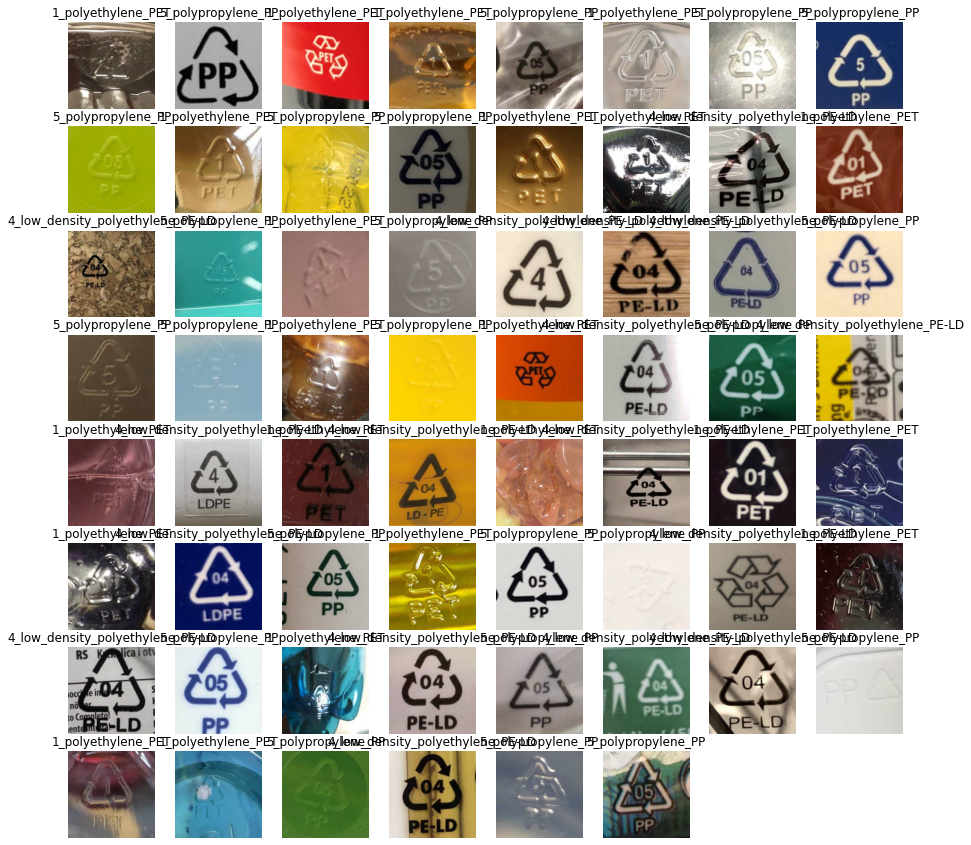

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
5/5 [==============================] - 29s 6s/step - loss: 0.0206 - accuracy: 0.9968
Epoch 2/20
5/5 [==============================] - 29s 6s/step - loss: 0.0150 - accuracy: 0.9968
Epoch 3/20
5/5 [==============================] - 29s 6s/step - loss: 0.0115 - accuracy: 0.9935
Epoch 4/20
5/5 [==============================] - 29s 6s/step - loss: 0.0082 - accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 29s 6s/step - loss: 0.0059 - accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 29s 6s/step - loss: 0.0056 - accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 29s 6s/step - loss: 0.0042 - accuracy: 1.0000
Epoch 8/20
5/5 [==============================] - 29s 6s/step - loss: 0.0035 - accuracy: 1.0000
Epoch 9/20
5/5 [==============================] - 29s 6s/step - loss: 0.0030 - accuracy: 1.0000
Epoch 10/20
5/5 [==============================] - 29s 6s/step - loss: 0.0031 - accuracy: 1.0000
Epoch 11/20
5/5 [======================

In [33]:
model.evaluate(test_ds)

2/2 [==============================] - 3s 2s/step - loss: 0.5785 - accuracy: 0.9274


[0.5785387754440308, 0.9274193644523621]

In [34]:
acc = history.history['accuracy']
loss = history.history['loss']

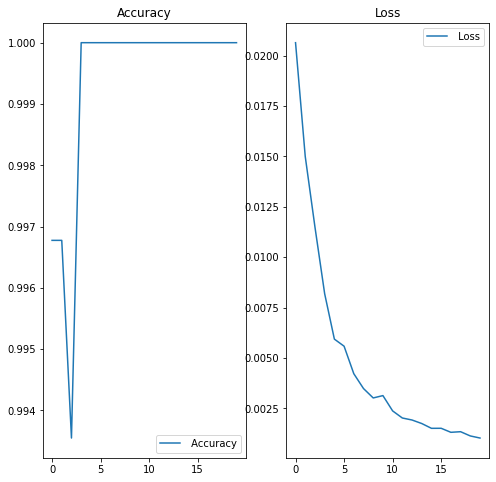

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

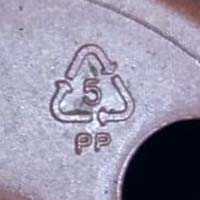

In [24]:
image_path = "/gdrive/My Drive/VXNF9927.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [25]:
pred = model.predict(scaled_img)

In [26]:
output = class_names[np.argmax(pred)]

In [27]:
output

'5_polypropylene_PP'

In [28]:
model.save("Plastic Recycling Codes.h5")